## 0. Import statements

In [207]:
import sbmlnetwork
import libsbml

import pandas as pd
import tellurium as te
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [208]:
rxns = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M1.csv')

In [209]:
def get_kegg_orthology_ids(reaction_ids):
    orthology_dict = {}
    for reaction_id in reaction_ids:
        url = f"https://www.kegg.jp/dbget-bin/www_bget?rn:{reaction_id}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the orthology section
        orthology_section = soup.find('th', string="Orthology")
        if orthology_section:
            # Get the orthology ID from the adjacent <td> tag
            orthology_ids = orthology_section.find_next('td').find_all('a')
            # Filter IDs that start with 'K'
            orthology_dict[reaction_id] = [ortho_id.get_text() for ortho_id in orthology_ids if ortho_id.get_text().startswith('K')]
        else:
            orthology_dict[reaction_id] = []
    
    return orthology_dict

In [210]:
orthology_ids = get_kegg_orthology_ids(rxns['Reaction ID'])

In [211]:
pathway = KGML_parser.read(open('ko01100.xml', 'r'))

In [212]:
import xml.etree.ElementTree as ET
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

def map_reaction_to_entry_id(xml_file_path, reaction_orthology_dict):
    # Parse the XML file
    pathway = KGML_parser.read(open(xml_file_path, 'r'))

    # Initialize dictionary to hold the reaction ID -> entry ID mapping
    reaction_entry_map = {}

    # Loop through each entry in the pathway
    for entry in pathway.entries.values():
        # Check if the entry is of type 'ortholog'
        if entry.type == "ortholog":
            # Extract the orthology IDs (split by space, remove 'ko:' prefix)
            orthology_ids_in_entry = entry.name.replace('ko:', '').split()

            # Convert to set for comparison
            orthology_ids_in_entry_set = set(orthology_ids_in_entry)

            # Loop through the reaction dictionary
            for reaction_id, orthology_ids in reaction_orthology_dict.items():
                if len(orthology_ids)==0:
                    continue
                # Convert orthology_ids from the reaction dictionary to a set
                orthology_ids_set = set(orthology_ids)

                # Check if all orthology IDs in the entry are present in orthology_ids_set
                if orthology_ids_set.issubset(orthology_ids_in_entry_set):
                    # Add the mapping to the dictionary
                    if reaction_id not in reaction_entry_map:
                        reaction_entry_map[reaction_id] = []
                    reaction_entry_map[reaction_id].append(entry.id)  # Save the entry ID

    return reaction_entry_map

In [213]:
xml_file = 'ko01100.xml'
reaction_entry_map = map_reaction_to_entry_id(xml_file, orthology_ids)

In [214]:
pathway = KGML_parser.read(open(xml_file, 'r'))
reaction_dict = reaction_entry_map
    
# Initialize dictionary to hold the cpd ID and Reaction ID mapping
cpd_coordinates_map = {}

# Loop through the reaction dictionary
for reaction_id, entry_ids in reaction_dict.items():
    for entry_id in entry_ids:
        # Search for the reaction in the pathway
        reaction_entry = next((reaction for reaction in pathway.reactions if reaction.id == entry_id), None)
        #print(reaction_entry)

        if reaction_entry:

            # Collect substrates
            for substrate in reaction_entry._substrates:
                substrate_entry = next((sub for sub in pathway.entries.values() if sub.id == substrate), None)
                x, y = substrate_entry.graphics[0].x, substrate_entry.graphics[0].y
                
                rxnentry = str(reaction_entry)
                # Split the string into lines and find the line containing 'Substrates'
                substrates_line = next(line for line in rxnentry.splitlines() if 'Substrates:' in line)
                # Extract the part of the line after 'Substrates:'
                substrates_part = substrates_line.split('Substrates: ')[1]
                # Split the substrates by comma and strip the 'cpd:' prefix
                cpd_id = [substrate.strip().replace('cpd:', '') for substrate in substrates_part.split(',')][0]

                cpd_coordinates_map[f"{cpd_id}_{reaction_id}"] = (x, y)

            # Collect products
            for product in reaction_entry._products:
                product_entry = next((prod for prod in pathway.entries.values() if prod.id == product), None)
                x, y = product_entry.graphics[0].x, product_entry.graphics[0].y
                
                rxnentry = str(reaction_entry)
                # Split the string into lines and find the line containing 'Substrates'
                products_line = next(line for line in rxnentry.splitlines() if 'Products:' in line)
                # Extract the part of the line after 'Substrates:'
                products_part = products_line.split('Products: ')[1]
                # Split the substrates by comma and strip the 'cpd:' prefix
                cpd_id = [product.strip().replace('cpd:', '') for product in products_part.split(',')][0]

                cpd_coordinates_map[f"{cpd_id}_{reaction_id}"] = (x, y)

In [215]:
cpd_coordinates_map

{'C00037_R00945': (2280.0, 2169.0),
 'C00101_R00945': (4553.0, 791.0),
 'C00065_R00945': (2965.0, 1713.0),
 'C04377_R00945': (2057.0, 2696.0),
 'C00143_R00945': (4788.0, 792.0),
 'C00037_R09099': (2280.0, 2169.0),
 'C00101_R09099': (4553.0, 791.0),
 'C00065_R09099': (2965.0, 1713.0),
 'C04377_R09099': (2057.0, 2696.0),
 'C00143_R09099': (4788.0, 792.0),
 'C00506_R00355': (3361.0, 1401.0),
 'C05528_R00355': (2901.0, 1472.0),
 'C05946_R00355': (2790.0, 2304.0),
 'C05947_R00355': (3297.0, 2304.0),
 'C00079_R00355': (3101.0, 1268.0),
 'C00166_R00355': (3195.0, 1268.0),
 'C00957_R00355': (3106.0, 1429.0),
 'C00097_R00355': (3240.0, 1429.0),
 'C00082_R00355': (3307.0, 1083.0),
 'C01179_R00355': (3307.0, 1210.0),
 'C00036_R00355': (3271.0, 2333.0),
 'C00049_R00355': (2709.0, 2013.0),
 'C05527_R00355': (3145.0, 1443.0),
 'C00606_R00355': (3145.0, 1322.0),
 'C00065_R00590': (2965.0, 1713.0),
 'C02218_R00590': (3467.0, 1594.0),
 'C00022_R00590': (2399.0, 1713.0),
 'C00361_R00200': (4160.0, 378.0

## 1. Retrieve coordinates from KEGG

### 1a. Draw KEGG map including only the reactions in our CSV file

In [216]:
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
pathway = KGML_parser.read(open('ko01100.xml', 'r'))

#get pathway that only has the reactions we care about
import pandas as pd
myrxns = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M1.csv')['Reaction ID']

rxns_map = ','.join(sum([r.name.split() for r in list(pathway.reactions)],[]))

import numpy as np
from copy import deepcopy

my_pathway = deepcopy(pathway)
rxn_dict = {r.name:r for r in list(pathway.reactions)}
for k,r in pathway._reactions.items():
    if not np.any([myr in r.name for myr in myrxns]):
        my_pathway.remove_entry(pathway.entries[k])
        my_pathway.remove_reaction(r)

reactants = sum([list(r.reactant_ids) for r in list(my_pathway.reactions)],[])

for k,e in pathway.entries.items():
    if 'cpd' in e.name:
        if e.id not in reactants:
            try:
                my_pathway.remove_entry(e)
            except:
                pass
    elif 'gl' in e.name:
        try:
            my_pathway.remove_entry(e)
        except:
            pass
    else:
        pass

canvas = KGMLCanvas(my_pathway, import_imagemap=False, show_orthologs=False, fontsize=12)
canvas.draw('drawings/M1_KEGG_map.pdf')

### 1b. Get the (x,y) coordinates for each species in the KEGG map

Also plot the coordinates to confirm they look correct.

In [217]:
KEGG_spec_dict = {}
KEGG_specs = []
KEGG_specCoords = []

#for all the entries in my_pathway, get just the compounds
#get species ID + entry ID + coordinates for that specific compound
#KEGG_spec_dict has keys as speciesID_entryID and values as coordinates
for k,e in pathway.entries.items():
    if e.type == 'compound':
        name = str(e.name) + "_" + str(e.id)
        KEGG_specs.append(name)
        KEGG_specCoords.append((e.graphics[0].x, e.graphics[0].y))

KEGG_specs_final = [spec.replace("cpd:","") for spec in KEGG_specs]

for i in range(len(KEGG_specs_final)):
    KEGG_spec_dict[KEGG_specs_final[i]] = KEGG_specCoords[i]

print(KEGG_spec_dict)

{'C07204_8229': (4502.0, 2684.0), 'C07201_8228': (4590.0, 2684.0), 'C01667_6222': (4037.0, 2063.0), 'C08542_7693': (3698.0, 739.0), 'C08552_7692': (3631.0, 739.0), 'C08543_7690': (3477.0, 843.0), 'C08538_7685': (3433.0, 878.0), 'C06314_7683': (1138.0, 1035.0), 'C06315_7682': (1078.0, 987.0), 'C14815_7681': (1078.0, 1035.0), 'C04577_7680': (1078.0, 1233.0), 'C14732_7678': (1123.0, 955.0), 'C08307_7623': (4319.0, 2010.0), 'C00855_7539': (3287.0, 2197.0), 'C00630_7111': (4511.0, 1258.0), 'C22141_7092': (3398.0, 2866.0), 'C10874_7072': (4809.0, 1668.0), 'C22149_7062': (3584.0, 1724.0), 'C07578_7046': (4540.0, 861.0), 'C06972_7044': (4436.0, 744.0), 'C16138_6805': (2923.0, 2958.0), 'C12014_6739': (1360.0, 515.0), 'C06689_6737': (1000.0, 515.0), 'C16754_6710': (540.0, 522.0), 'C12467_6684': (4463.0, 900.0), 'C21093_6623': (489.0, 2090.0), 'C20981_6591': (4354.0, 1194.0), 'C21136_6584': (4045.0, 2825.0), 'gl:G13115_6555': (1418.0, 778.0), 'C06802_6544': (880.0, 940.0), 'C21156_6543': (950.0, 

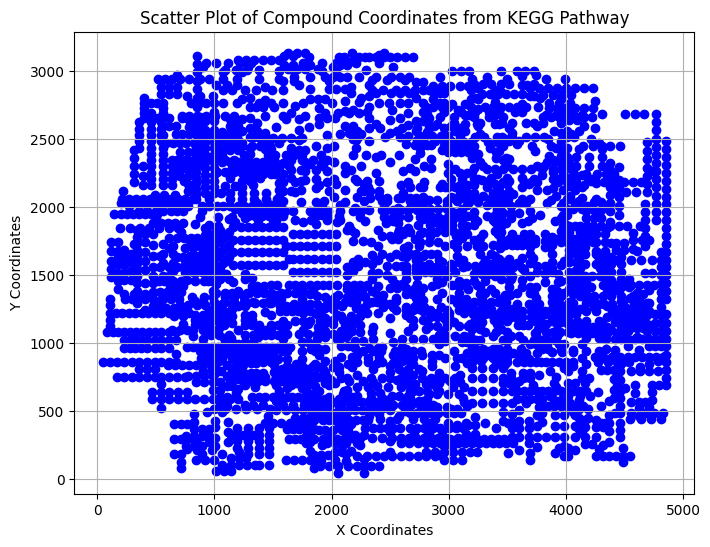

In [218]:
# Extract x and y coordinates from the dictionary
x_coords = [coords[0] for coords in KEGG_spec_dict.values()]
y_coords = [coords[1] for coords in KEGG_spec_dict.values()]

plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.scatter(x_coords, y_coords, color='blue', marker='o')

plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Scatter Plot of Compound Coordinates from KEGG Pathway')
plt.grid(True)
plt.show()

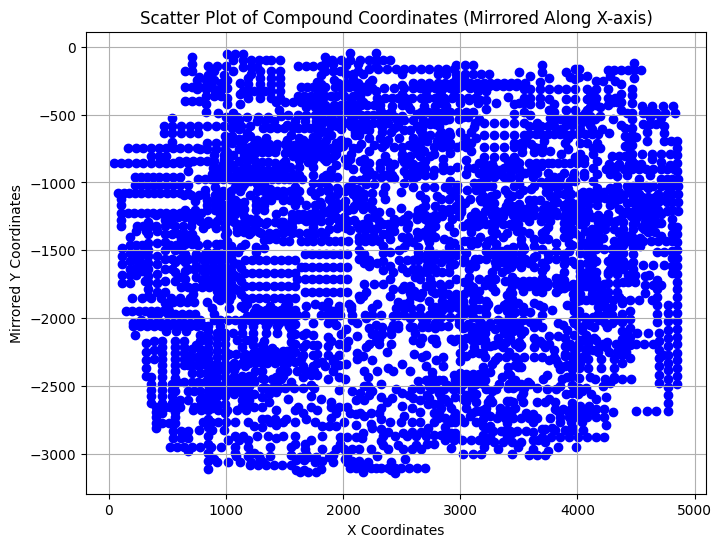

In [219]:
y_coords_mirrored = [-y for y in y_coords]

plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords_mirrored, color='blue', marker='o')
plt.xlabel('X Coordinates')
plt.ylabel('Mirrored Y Coordinates')
plt.title('Scatter Plot of Compound Coordinates (Mirrored Along X-axis)')
plt.grid(True)
plt.show()

### 1c. Match the species to the associated reaction

In [220]:
def reactionsCSV(csv_file_path):
    df = pd.read_csv(csv_file_path)
    reactions = df['Reaction ID'].tolist()
    return reactions

In [221]:
#get the reactions csv 
reactionsList = reactionsCSV('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M1.csv')

#this will store reactionID: speciesID_entryID
specs_in_rxns = {}

for r in my_pathway.reactions:
    rxns = r.name.replace("rn:", "").split()
    for rxn in rxns:
        for sub, prod in zip(r.substrates, r.products):
            specs_in_rxns[rxn] = [sub.name + '_' + str(sub.id), prod.name + '_' + str(prod.id)]

print(specs_in_rxns)

{'R00351': ['cpd:C00036_6237', 'cpd:C00158_6238'], 'R00352': ['cpd:C00036_6237', 'cpd:C00158_6238'], 'R00199': ['cpd:C00074_4243', 'cpd:C00022_4484'], 'R00200': ['cpd:C00074_4243', 'cpd:C00022_4484'], 'R00206': ['cpd:C00074_4243', 'cpd:C00022_4484'], 'R02320': ['cpd:C00074_4243', 'cpd:C00022_4484'], 'R00209': ['cpd:C00022_4484', 'cpd:C00024_6239'], 'R00212': ['cpd:C00022_4484', 'cpd:C00024_6239'], 'R01196': ['cpd:C00022_4484', 'cpd:C00024_6239'], 'R10866': ['cpd:C00022_4484', 'cpd:C00024_6239'], 'R05605': ['cpd:C00118_5693', 'cpd:C04442_4486'], 'R00341': ['cpd:C00074_5706', 'cpd:C00036_5708'], 'R00345': ['cpd:C00074_5706', 'cpd:C00036_5708'], 'R00346': ['cpd:C00036_6237', 'cpd:C00074_4243'], 'R00431': ['cpd:C00036_6237', 'cpd:C00074_4243'], 'R00726': ['cpd:C00036_6237', 'cpd:C00074_4243'], 'R00217': ['cpd:C00036_6237', 'cpd:C00022_4484'], 'R00344': ['cpd:C00036_6237', 'cpd:C00022_4484'], 'R12212': ['cpd:C00036_6237', 'cpd:C00022_4484'], 'R00220': ['cpd:C00022_4484', 'cpd:C00065_5902'],

### 1d. Combine parts 1b and 1c to create a dictionary: {speciesID_reactionID: (x,y)}

In [222]:
#now we have a dictionary with the coordinates for the species, and we have a dictionary with the species associated with each reaction ID

#match the speciesID_entryID with the correct reaction
complete_dict = {}
spec_keys = []
coords = []

for reaction, compounds in specs_in_rxns.items():
    for compound in compounds:
        if compound in KEGG_specs:
            #print(compound)
            updated_comp = compound.replace("cpd:", "")
            updated_comp_final = updated_comp.split('_')[0] #get rid of entry ID
            updated_rxn = reaction.replace("rn:", "")
            spec_keys.append(updated_comp_final + '_' + str(updated_rxn)) #make the new ID have speciesID_rxnID
            coords.append(KEGG_spec_dict[updated_comp])

for i in range(len(spec_keys)):
    complete_dict[spec_keys[i]] = coords[i]

#this dictionary now has unique keys for every species: speciesID_reactionID
print(complete_dict)

{'C00036_R00351': (2321.0, 1979.0), 'C00158_R00351': (2464.0, 1977.0), 'C00036_R00352': (2321.0, 1979.0), 'C00158_R00352': (2464.0, 1977.0), 'C00074_R00199': (2399.0, 1614.0), 'C00022_R00199': (2399.0, 1713.0), 'C00074_R00200': (2399.0, 1614.0), 'C00022_R00200': (2399.0, 1713.0), 'C00074_R00206': (2399.0, 1614.0), 'C00022_R00206': (2399.0, 1713.0), 'C00074_R02320': (2399.0, 1614.0), 'C00022_R02320': (2399.0, 1713.0), 'C00022_R00209': (2399.0, 1713.0), 'C00024_R00209': (2399.0, 1834.0), 'C00022_R00212': (2399.0, 1713.0), 'C00024_R00212': (2399.0, 1834.0), 'C00022_R01196': (2399.0, 1713.0), 'C00024_R01196': (2399.0, 1834.0), 'C00022_R10866': (2399.0, 1713.0), 'C00024_R10866': (2399.0, 1834.0), 'C00118_R05605': (2399.0, 1220.0), 'C04442_R05605': (2764.0, 943.0), 'C00074_R00341': (2172.0, 3078.0), 'C00036_R00341': (2234.0, 3105.0), 'C00074_R00345': (2172.0, 3078.0), 'C00036_R00345': (2234.0, 3105.0), 'C00036_R00346': (2321.0, 1979.0), 'C00074_R00346': (2399.0, 1614.0), 'C00036_R00431': (23

In [223]:
print(cpd_coordinates_map)

{'C00037_R00945': (2280.0, 2169.0), 'C00101_R00945': (4553.0, 791.0), 'C00065_R00945': (2965.0, 1713.0), 'C04377_R00945': (2057.0, 2696.0), 'C00143_R00945': (4788.0, 792.0), 'C00037_R09099': (2280.0, 2169.0), 'C00101_R09099': (4553.0, 791.0), 'C00065_R09099': (2965.0, 1713.0), 'C04377_R09099': (2057.0, 2696.0), 'C00143_R09099': (4788.0, 792.0), 'C00506_R00355': (3361.0, 1401.0), 'C05528_R00355': (2901.0, 1472.0), 'C05946_R00355': (2790.0, 2304.0), 'C05947_R00355': (3297.0, 2304.0), 'C00079_R00355': (3101.0, 1268.0), 'C00166_R00355': (3195.0, 1268.0), 'C00957_R00355': (3106.0, 1429.0), 'C00097_R00355': (3240.0, 1429.0), 'C00082_R00355': (3307.0, 1083.0), 'C01179_R00355': (3307.0, 1210.0), 'C00036_R00355': (3271.0, 2333.0), 'C00049_R00355': (2709.0, 2013.0), 'C05527_R00355': (3145.0, 1443.0), 'C00606_R00355': (3145.0, 1322.0), 'C00065_R00590': (2965.0, 1713.0), 'C02218_R00590': (3467.0, 1594.0), 'C00022_R00590': (2399.0, 1713.0), 'C00361_R00200': (4160.0, 378.0), 'C00286_R00200': (4257.0

## 2. Apply KEGG coordinates to SBMLNetwork layout

### 2a. Remove enzymes, inhibitors, and cofactors from the visual.

In [224]:
#remove any unused species
def remove_unused_species(sbml_file, output_file):
    # Read SBML file
    reader = libsbml.SBMLReader()
    document = reader.readSBML(sbml_file)
    model = document.getModel()
    
    if model is None:
        print("Failed to read model from SBML file.")
        return

    # Collect IDs of all species involved in reactions
    used_species = set()
    for reaction in model.getListOfReactions():
        for reactant in reaction.getListOfReactants():
            used_species.add(reactant.getSpecies())
        for product in reaction.getListOfProducts():
            used_species.add(product.getSpecies())
        for modifier in reaction.getListOfModifiers():
            used_species.add(modifier.getSpecies())
    
    # Collect IDs of all species in the model
    all_species = {species.getId() for species in model.getListOfSpecies()}
    
    # Determine unused species
    unused_species = all_species - used_species
    
    # Remove unused species
    for species_id in unused_species:
        species = model.getSpecies(species_id)
        model.removeSpecies(species_id)

    # Write the updated model to a new SBML file
    writer = libsbml.SBMLWriter()
    writer.writeSBMLToFile(document, output_file)
    print(f"Updated SBML file saved to {output_file}")

In [225]:
# M1_original = '/Users/stellaanastasakis/Downloads/Carothers_Code/SBML_models/240705_M1.sbml.xml'
# M1_modified = '/Users/stellaanastasakis/Downloads/Carothers_Code/SBML_models/M1_noExtras.sbml'
# remove_unused_species(M1_original, M1_modified)

In [226]:
#remove enzymes
def remove_ecs(input_filename, output_filename):
    # Load SBML document
    document = libsbml.readSBMLFromFile(input_filename)
    if document.getNumErrors() > 0:
        raise Exception('Error reading SBML file.')
    
    # Get model from document
    model = document.getModel()
    if model is None:
        raise Exception('No model found in the SBML document.')
    
    # Loop through reactions
    for i in range(model.getNumReactions()):
        reaction = model.getReaction(i)
        reactants = set(reaction.getReactant(j).getSpecies() for j in range(reaction.getNumReactants()))
        products = set(reaction.getProduct(j).getSpecies() for j in range(reaction.getNumProducts()))
        
        mutual_species = reactants & products
        
        for species in mutual_species:
            for j in range(reaction.getNumReactants()):
                if reaction.getReactant(j).getSpecies() == species:
                    reaction.removeReactant(j)
                    break  # Break after removing to avoid index issues

            for j in range(reaction.getNumProducts()):
                if reaction.getProduct(j).getSpecies() == species:
                    reaction.removeProduct(j)
                    break  # Break after removing to avoid index issues

    # Save the modified SBML document
    success = libsbml.writeSBMLToFile(document, output_filename)
    print(f"Updated SBML file saved to {output_filename}")
    if not success:
        raise Exception('Error writing SBML file.')

In [227]:
def remove_ECs_2(file_in, file_out):
    # Read the SBML file
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_in)
    model = document.getModel()
    
    if model is None:
        raise ValueError("Could not find a valid model in the SBML file.")
    
    # Collect the species to remove
    species_to_remove = []
    for species in model.getListOfSpecies():
        if species.getName().startswith("EC"):
            species_to_remove.append(species)

    # Remove the collected species
    for species in species_to_remove:
        model.removeSpecies(species.getId())

    # Write the modified SBML to a new file
    writer = libsbml.SBMLWriter()
    writer.writeSBMLToFile(document, file_out)
    
    print(f"Modified SBML saved to {file_out}")

In [228]:
# M1_wECs = '/Users/stellaanastasakis/Downloads/Carothers_Code/SBML_models/M1_noExtras.sbml'
# M1_woutECS = '/Users/stellaanastasakis/Downloads/Carothers_Code/SBML_models/M1_final.sbml'
# remove_ecs(M1_wECs, M1_woutECS)
# remove_ECs_2(M1_woutECS, '/Users/stellaanastasakis/Downloads/Carothers_Code/SBML_models/M1_final_v2.sbml')

In [231]:
#Change this path to get new model
M1 = sbmlnetwork.load('M1_final_v2.sbml')

### 2b. Match reaction labels (our convention) with reaction IDs (KEGG convention)

In [232]:
M1_reaction_labels = M1.getListOfReactionIds()

df = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M1.csv')
label_to_reaction_id = dict(zip(df['Label'], df['Reaction ID']))
M1_reactionIDs = [label_to_reaction_id.get(item, item) for item in M1_reaction_labels]

print(f'List of reaction labels: {M1_reaction_labels}')
print()
print(f'List of corresponding reaction IDs: {M1_reactionIDs}')

label_to_ID_dict = {}
i = 0
for label in M1_reaction_labels:
    label_to_ID_dict[label] = M1_reactionIDs[i]
    i = i+1

print()
print(label_to_ID_dict)

List of reaction labels: ['R21', 'R22', 'R23', 'R32', 'R50', 'R61', 'R71', 'R77', 'R78', 'R79', 'R95', 'R96', 'R113', 'R130', 'R131', 'R132', 'R133', 'R134', 'R135', 'R136', 'R137', 'R167', 'R207', 'R208', 'R309', 'R310', 'R358', 'R359', 'R360', 'R361', 'R362', 'R364', 'R376', 'R377', 'R379', 'R401', 'R402', 'R405', 'R415', 'R599', 'R704', 'R705', 'R706', 'R707', 'R708', 'R709']

List of corresponding reaction IDs: ['R01699', 'R00014', 'R00209', 'R00209', 'R00209', 'R00342', 'R00199', 'R00945', 'R09099', 'R01082', 'R95', 'R96', 'R02628', 'R00200', 'R00430', 'R00572', 'R00659', 'R00724', 'R01138', 'R01858', 'R02320', 'R00673', 'R00216', 'R00217', 'R05605', 'R00471', 'R00006', 'R00226', 'R00014', 'R03050', 'R04672', 'R08648', 'R00220', 'R00590', 'R08698', 'R00214', 'R00217', 'R00220', 'R01811', 'R00704', 'R00344', 'R00519', 'R00220', 'R00590', 'R06131', 'R08698']

{'R21': 'R01699', 'R22': 'R00014', 'R23': 'R00209', 'R32': 'R00209', 'R50': 'R00209', 'R61': 'R00342', 'R71': 'R00199', 'R77'

In [233]:
def getSpecsinRxn(reaction):
    #get the number of species involved in the reaction
    numSpecs = M1.getNumSpeciesReferenceGlyphs(reaction, reaction_glyph_index=0, layout_index=0)
    specList = []
    for i in range(numSpecs):
        #get the ID of each species
        specID = M1.getSpeciesReferenceSpeciesId(reaction, reaction_glyph_index=0, species_reference_glyph_index=i, layout_index=0)
        specList.append(specID)
    return specList

In [234]:
specs_in_rxns = {}
for label in M1_reaction_labels:
    specs_in_rxns[label] = getSpecsinRxn(label)

print(specs_in_rxns)

{'R21': ['C00022', 'C15972', 'C00011', 'C16255'], 'R22': ['C00022', 'C00068', 'C00011', 'C05125'], 'R23': ['C00003', 'C00010', 'C00022', 'C00004', 'C00011', 'C00024', 'C00080'], 'R32': ['C00003', 'C00010', 'C00022', 'C00004', 'C00011', 'C00024', 'C00080'], 'R50': ['C00003', 'C00010', 'C00022', 'C00004', 'C00011', 'C00024', 'C00080'], 'R61': ['C00003', 'C00149', 'C00004', 'C00036', 'C00080'], 'R71': ['C00001', 'C00002', 'C00022', 'C00009', 'C00020', 'C00074'], 'R77': ['C00001', 'C00037', 'C00143', 'C00065', 'C00101'], 'R78': ['C00065', 'C01217', 'C00001', 'C00037', 'C04377'], 'R79': ['C00149', 'C00001', 'C00122'], 'R95': ['C00002', 'C00065', 'C01650', 'C00013', 'C00020', 'C02553'], 'R96': ['C00002', 'C00065', 'C16636', 'C00013', 'C00020', 'C06481'], 'R113': ['C00074', 'C00615', 'C00022', 'C04261'], 'R130': ['C00002', 'C00022', 'C00008', 'C00074'], 'R131': ['C00022', 'C00044', 'C00035', 'C00074'], 'R132': ['C00022', 'C00063', 'C00074', 'C00112'], 'R133': ['C00022', 'C00075', 'C00015', 'C

### 2c. Set the coordinates in SBMLNetwork.

Save those coordinates in a list to fix autolayout locked_nodes parameter.

In [235]:
#get the graphical_object_index for species w/ alias nodes
def aliasIndexExtract(speciesID, reactionID, model):
    for i in range(model.getNumSpeciesReferenceGlyphs(reactionID)):
        specglyphID = model.getSpeciesReferenceSpeciesGlyphId(reactionID, species_reference_glyph_index=i)
        for j in range(model.getNumSpeciesGlyphs(speciesID)):
            objID = model.getNthSpeciesGlyphId(speciesID, j)
            if objID == specglyphID:
                return j
    return -1

In [239]:
set_nodes = []
for rxn_label, specs in specs_in_rxns.items():
    corresponding_ID = label_to_ID_dict[rxn_label]
    for spec in specs:
        spec_react = spec + '_' + corresponding_ID
        index = aliasIndexExtract(spec, rxn_label, M1)
        if spec_react in complete_dict.keys():
            coords = complete_dict[spec_react]
            set_nodes.append(spec)
        else:
            coords = (-1,-1)


        M1.setX(spec, coords[0], graphical_object_index=index)
        M1.setY(spec, coords[1], graphical_object_index=index)

        print(f'{spec_react} in {rxn_label}/{corresponding_ID} has graphical_object_index {index} and coordinates of {coords} from KEGG')

C00022_R01699 in R21/R01699 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C15972_R01699 in R21/R01699 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00011_R01699 in R21/R01699 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C16255_R01699 in R21/R01699 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00022_R00014 in R22/R00014 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00068_R00014 in R22/R00014 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00011_R00014 in R22/R00014 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C05125_R00014 in R22/R00014 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00003_R00209 in R23/R00209 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00010_R00209 in R23/R00209 has graphical_object_index 0 and coordinates of (-1, -1) from KEGG
C00022_R00209 in R23/R00209 has graphical_object_i

ValueError: Could not save to JPEG for display

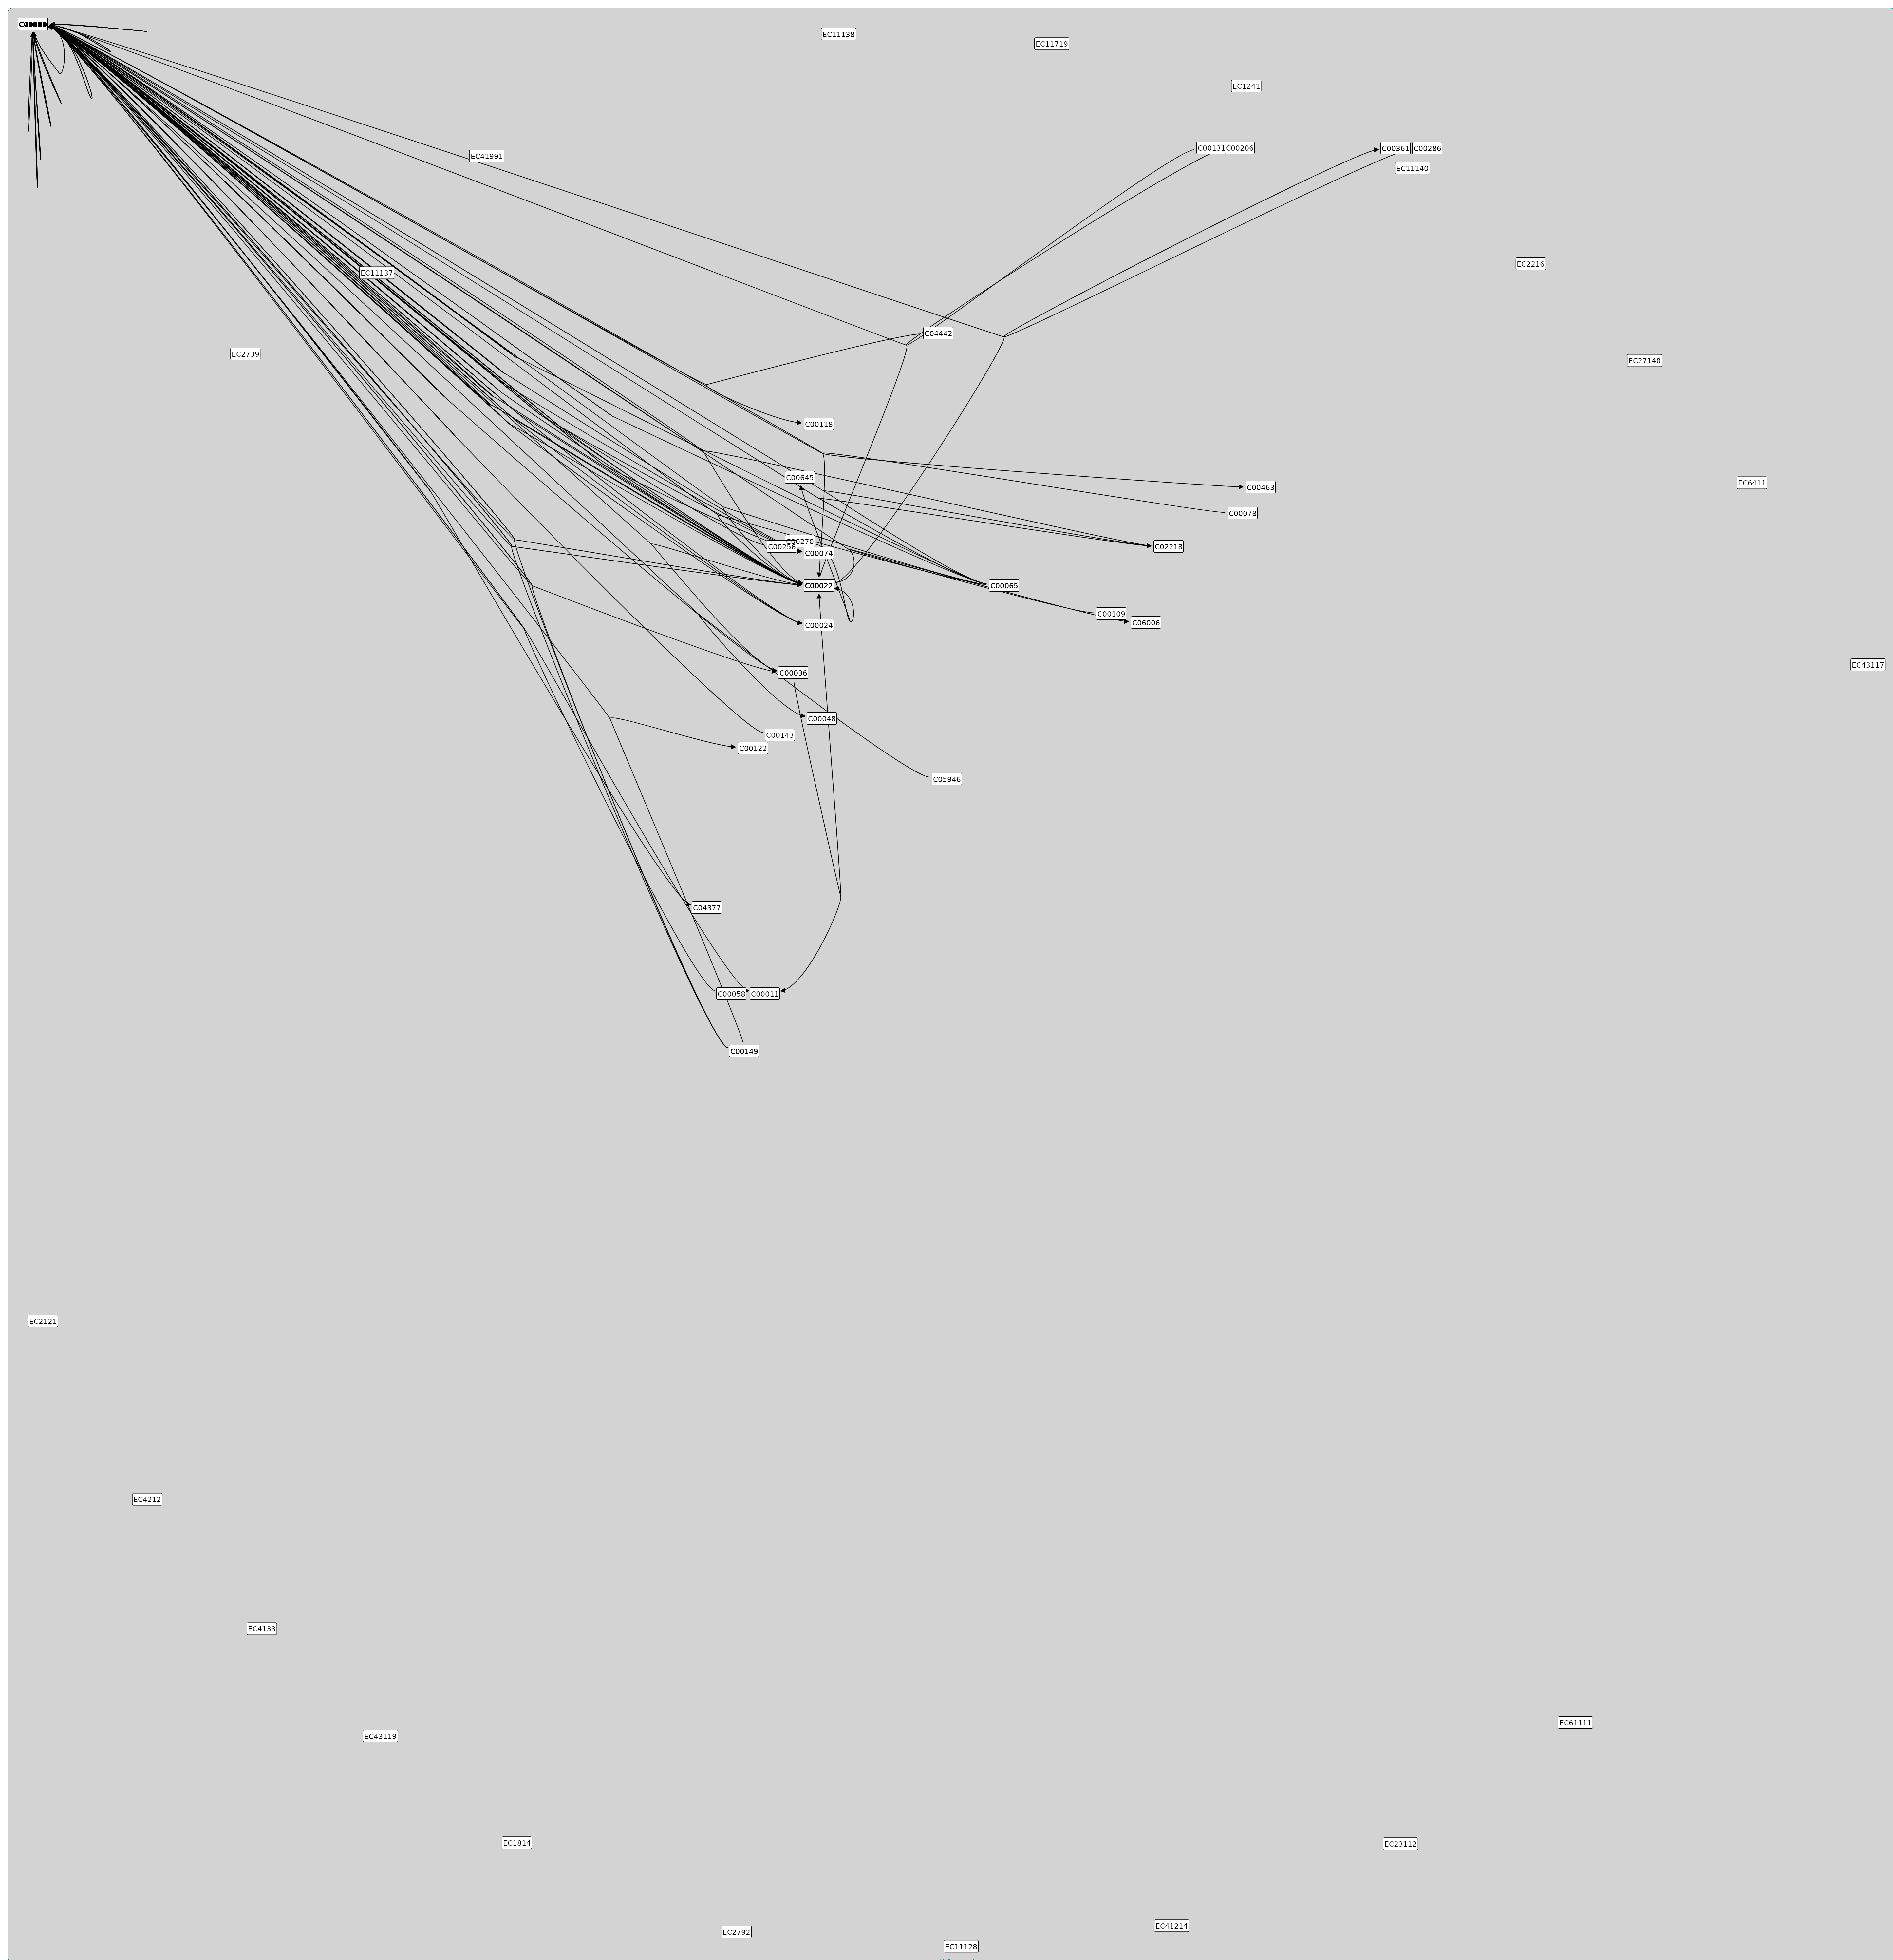

In [240]:
M1.draw()

In [23]:
M1.autolayout(locked_nodes=set_nodes)

0